In [1]:
import csv
import cv2
import numpy as np
import math
import matplotlib.image as mpimg

In [2]:
lines = []
with open('../data/driving_log_withoutHeader.csv') as csvfile:
    reader = csv.reader(csvfile)
    print("csvfile-->",csvfile)
    for line in reader:
        lines.append(line)

csvfile--> <_io.TextIOWrapper name='../data/driving_log_withoutHeader.csv' mode='r' encoding='UTF-8'>


In [3]:
print("lines Length->",len(lines))

lines Length-> 8036


In [4]:
def resize_image(img):
    shape = img.shape
    image = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)    
    return img

def pre_processImage(img):
    image = resize_image(img)
    return image

In [5]:
images = []
measurements = []
correction = 0.20 # this is a parameter to tune

i = 0
shift_angle = 0
for line in lines:
    k=1
    shift_angle = 0
    for k in range(3):
        source_path = line[k]
        filename = source_path.split('/')[-1]
        current_path = '../data/IMG/' + filename
        
        #image = pre_processImage(image)
        measurement = float(line[3])
        if k==0:
            measurement = measurement
        if k==1:
            measurement = measurement + correction 
        if k==2:
            measurement = measurement - correction 
        image=mpimg.imread(current_path)
        image = pre_processImage(image)
        image = np.array(image)
        random_val = np.random.randint(2)
        if random_val==0:
            image = cv2.flip(image,1)
            measurement = -measurement
        images.append(image)
        measurements.append(measurement)

24108
24108
2320


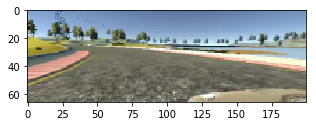

In [6]:
import random
import matplotlib.pyplot as plt


X_train = np.array(images)
y_train = np.array(measurements)

print(len(X_train))
print(len(y_train))

index = random.randint(0, len(X_train))
print(index)
image = X_train[index]

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()


In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D,Dropout
from keras.layers.convolutional import Cropping2D
from keras.regularizers import l2
from keras.layers.advanced_activations import ELU


ch, row, col = 66,200,3

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=(ch, row, col),output_shape=(ch, row, col)))
model.add(Cropping2D(cropping=((20,0), (0,0)), input_shape=(66,200,3)))

model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding = 'valid', activation='relu',name='Conv1'))
model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding = 'valid', activation='relu',name='Conv2'))
model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding = 'valid', activation='relu',name='Conv3'))
#model.add(MaxPooling2D())

model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), padding = 'valid', activation='relu',name='Conv5'))
#model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), padding = 'valid', activation='relu',name='Conv6'))

#model.add(MaxPooling2D())
model.add(Flatten())
#model.add(Dropout(.5))

model.add(Dense(100))
model.add(Dropout(.5))

model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs=20)

model.save('model.h5')

Using TensorFlow backend.


Train on 19286 samples, validate on 4822 samples
Epoch 1/20
19286/19286 [==============================] - 17s - loss: 0.0124 - val_loss: 0.0121